<a href="https://colab.research.google.com/github/ZiyanIshani/MLFinalProject/blob/main/MLFinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Define models
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
from google.colab import drive
drive.mount('/content/drive')


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),
                         (0.2470,0.2435,0.2616)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),
                         (0.2470,0.2435,0.2616)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train
)
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2
)

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, 3, stride, 1, bias=False)
        self.bn1   = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, 3, 1, 1, bias=False)
        self.bn2   = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes)
            )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(channels, channels//reduction, bias=False)
        self.fc2 = nn.Linear(channels//reduction, channels, bias=False)
    def forward(self, x):
        b,c,_,_ = x.size()
        y = x.mean((2,3))
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(b,c,1,1)
        return x * y

class ResNetCIFAR(nn.Module):
    def __init__(self, block, num_blocks, stem_c, use_preact, use_se):
        super().__init__()
        self.use_preact = use_preact
        self.conv1 = nn.Conv2d(3, stem_c, 3, 1, 1, bias=False)
        self.bn1   = nn.BatchNorm2d(stem_c)
        self.in_planes = stem_c
        self.use_se = use_se
        self.layer1 = self._make_layer(block, stem_c,     num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, stem_c*2,   num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, stem_c*4,   num_blocks[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc      = nn.Linear(stem_c*4, 10)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias,   0)
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            if self.use_se:
                layers.append(SEBlock(planes))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)
    def forward(self, x):
        if self.use_preact:
            out = self.conv1(x)
            out = F.relu(self.bn1(out))
        else:
            out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        return self.fc(out)

def get_model(name):
    return {
        'baseline': ResNetCIFAR(BasicBlock, [3,3,3], 16, use_preact=False, use_se=False),
        'stem':     ResNetCIFAR(BasicBlock, [3,3,3], 16, use_preact=True,  use_se=False),
        'se':       ResNetCIFAR(BasicBlock, [3,3,3], 16, use_preact=False, use_se=True),
    }[name]

def get_optimizer(model):
    return optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

def train_eval(model, epochs, name):
    model.to(device)
    optimizer = get_optimizer(model)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[82,123], gamma=0.1)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for e in range(epochs):
        model.train()
        tloss = tcorrect = ttotal = 0
        for x,y in trainloader:
            x,y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = F.cross_entropy(out, y)
            loss.backward()
            optimizer.step()
            tloss    += loss.item()
            preds     = out.argmax(1)
            ttotal  += y.size(0)
            tcorrect += preds.eq(y).sum().item()
        history['train_loss'].append(tloss/len(trainloader))
        history['train_acc'].append(100.*tcorrect/ttotal)
        model.eval()
        vloss = vcorrect = vtotal = 0
        with torch.no_grad():
            for x,y in testloader:
                x,y = x.to(device), y.to(device)
                out = model(x)
                l   = F.cross_entropy(out, y)
                vloss    += l.item()
                p         = out.argmax(1)
                vtotal  += y.size(0)
                vcorrect += p.eq(y).sum().item()
        history['val_loss'].append(vloss/len(testloader))
        history['val_acc'].append(100.*vcorrect/vtotal)
        scheduler.step()
        print(f"{e+1:02d} {name} val_acc={history['val_acc'][-1]:.2f}%")
    torch.save(history, f'hist_{name}.pth')
    torch.save(model.state_dict(), f'model_{name}.pth')
    return history


Mounted at /content/drive


100%|██████████| 170M/170M [00:18<00:00, 9.03MB/s]


In [ ]:
hist_base = train_eval(get_model('baseline'), 50, 'baseline')
torch.save(hist_base, '/content/drive/MyDrive/hist_baseline.pth')

01 baseline val_acc=46.30%
02 baseline val_acc=59.93%
03 baseline val_acc=63.96%
04 baseline val_acc=73.80%
05 baseline val_acc=73.36%
06 baseline val_acc=73.67%
07 baseline val_acc=76.35%
08 baseline val_acc=78.49%
09 baseline val_acc=74.44%
10 baseline val_acc=79.67%
11 baseline val_acc=80.61%
12 baseline val_acc=81.24%
13 baseline val_acc=77.07%
14 baseline val_acc=80.99%
15 baseline val_acc=80.47%
16 baseline val_acc=82.79%
17 baseline val_acc=83.28%
18 baseline val_acc=80.57%
19 baseline val_acc=85.58%
20 baseline val_acc=84.89%
21 baseline val_acc=83.92%
22 baseline val_acc=81.81%
23 baseline val_acc=82.55%
24 baseline val_acc=83.79%
25 baseline val_acc=81.63%
26 baseline val_acc=83.47%
27 baseline val_acc=81.03%
28 baseline val_acc=82.46%
29 baseline val_acc=83.62%
30 baseline val_acc=81.62%
31 baseline val_acc=82.38%
32 baseline val_acc=80.47%
33 baseline val_acc=85.15%
34 baseline val_acc=85.13%
35 baseline val_acc=81.50%
36 baseline val_acc=84.76%
37 baseline val_acc=85.70%
3

In [ ]:
hist_stem = train_eval(get_model('stem'), 50, 'stem')
torch.save(hist_stem, '/content/drive/MyDrive/hist_stem.pth')

01 stem val_acc=49.98%
02 stem val_acc=57.93%
03 stem val_acc=65.43%
04 stem val_acc=74.55%
05 stem val_acc=72.07%
06 stem val_acc=75.88%
07 stem val_acc=72.80%
08 stem val_acc=78.66%
09 stem val_acc=80.34%
10 stem val_acc=77.47%
11 stem val_acc=81.36%
12 stem val_acc=81.07%
13 stem val_acc=82.35%
14 stem val_acc=83.54%
15 stem val_acc=83.09%
16 stem val_acc=82.89%
17 stem val_acc=81.95%
18 stem val_acc=80.05%
19 stem val_acc=83.35%
20 stem val_acc=82.36%
21 stem val_acc=80.29%
22 stem val_acc=82.94%
23 stem val_acc=78.71%
24 stem val_acc=83.75%
25 stem val_acc=82.88%
26 stem val_acc=84.48%
27 stem val_acc=83.29%
28 stem val_acc=85.07%
29 stem val_acc=86.14%
30 stem val_acc=85.91%
31 stem val_acc=83.79%
32 stem val_acc=82.38%
33 stem val_acc=85.30%
34 stem val_acc=81.67%
35 stem val_acc=85.14%
36 stem val_acc=81.60%
37 stem val_acc=84.38%
38 stem val_acc=83.85%
39 stem val_acc=82.85%
40 stem val_acc=85.86%
41 stem val_acc=84.58%
42 stem val_acc=86.59%
43 stem val_acc=82.31%
44 stem val

In [ ]:
hist_se   = train_eval(get_model('se'), 50, 'se')
torch.save(hist_se, '/content/drive/MyDrive/hist_se.pth')

01 se val_acc=45.93%
02 se val_acc=57.12%
03 se val_acc=60.14%
04 se val_acc=69.49%
05 se val_acc=73.02%
06 se val_acc=76.67%
07 se val_acc=78.18%
08 se val_acc=78.52%
09 se val_acc=75.86%
10 se val_acc=79.12%
11 se val_acc=79.81%
12 se val_acc=80.60%
13 se val_acc=81.56%
14 se val_acc=75.27%
15 se val_acc=81.28%
16 se val_acc=82.66%
17 se val_acc=82.46%
18 se val_acc=82.85%
19 se val_acc=82.72%
20 se val_acc=81.24%
21 se val_acc=83.48%
22 se val_acc=84.34%
23 se val_acc=82.06%
24 se val_acc=83.16%
25 se val_acc=83.66%
26 se val_acc=83.81%
27 se val_acc=84.26%
28 se val_acc=84.04%
29 se val_acc=83.12%
30 se val_acc=85.22%
31 se val_acc=83.26%
32 se val_acc=85.08%
33 se val_acc=86.69%
34 se val_acc=84.22%
35 se val_acc=84.79%
36 se val_acc=84.60%
37 se val_acc=84.74%
38 se val_acc=85.36%
39 se val_acc=84.78%
40 se val_acc=84.86%
41 se val_acc=85.30%
42 se val_acc=85.76%
43 se val_acc=82.32%
44 se val_acc=85.04%
45 se val_acc=85.04%
46 se val_acc=84.17%
47 se val_acc=87.23%
48 se val_acc

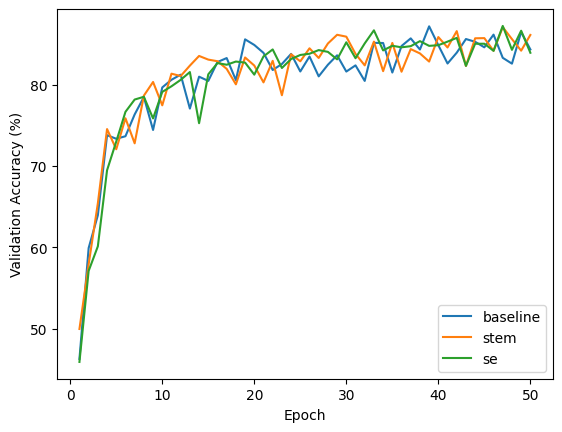

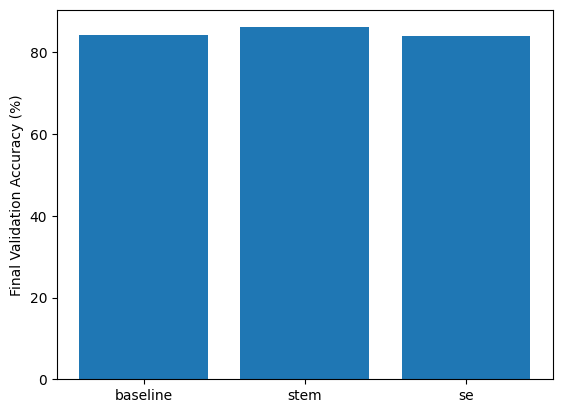

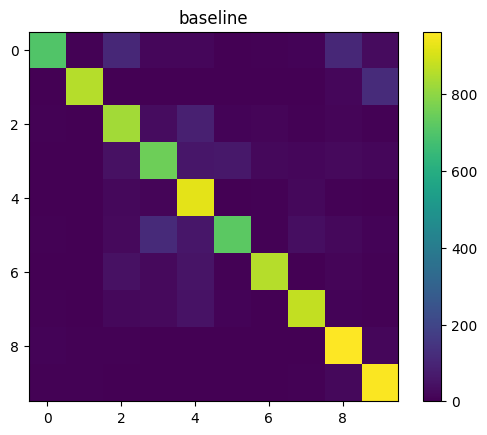

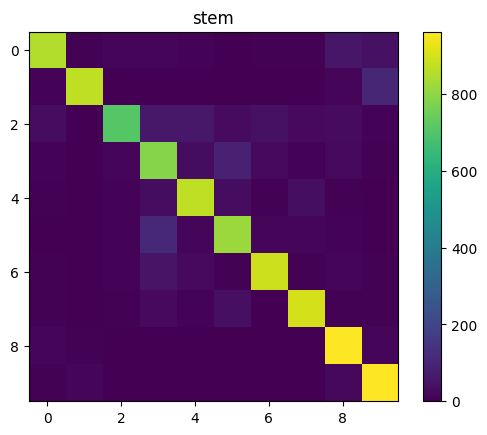

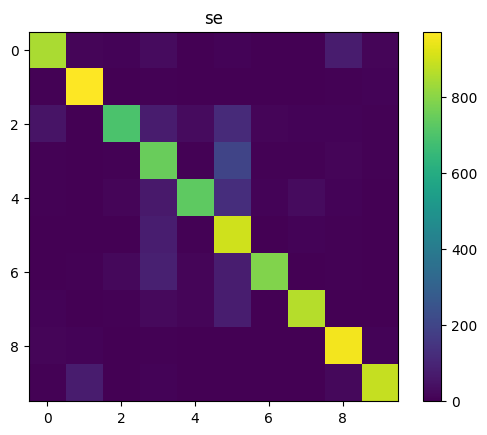

In [ ]:
#Plot Results
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

hists = {
    'baseline': hist_base,
    'stem':     hist_stem,
    'se':       hist_se,
}
epochs = np.arange(1, 51)

plt.figure()
for name, history in hists.items():
    plt.plot(epochs, history['val_acc'], label=name)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.savefig('compare_val_acc.pdf')

plt.figure()
final_acc = [history['val_acc'][-1] for history in hists.values()]
plt.bar(list(hists.keys()), final_acc)
plt.ylabel('Final Validation Accuracy (%)')
plt.savefig('final_acc_bar.pdf')

for name in hists:
    model = get_model(name).to(device)
    model.load_state_dict(torch.load(f'model_{name}.pth'))
    preds, targs = [], []
    model.eval()
    with torch.no_grad():
        for x, y in testloader:
            out = model(x.to(device))
            preds += out.argmax(1).cpu().tolist()
            targs += y.tolist()
    cm = confusion_matrix(targs, preds)
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(name)
    plt.colorbar()
    plt.savefig(f'confusion_matrix_{name}.pdf')


In [1]:
!nvidia-smi

Mon Apr 21 22:54:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----